In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df = pd.read_table('auto-mpg.data',delim_whitespace=True, header=None, names=['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name'])

In [3]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [5]:
df.shape

(398, 9)

In [6]:
#Data cleaning

#Horsepower has strings and integers removing six of the rows that didn't have information to be converted to float
df['horsepower'] = df['horsepower'].convert_objects(convert_numeric=True)

#Droping rows with NAN values
df = df.dropna()
df.shape

C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


(392, 9)

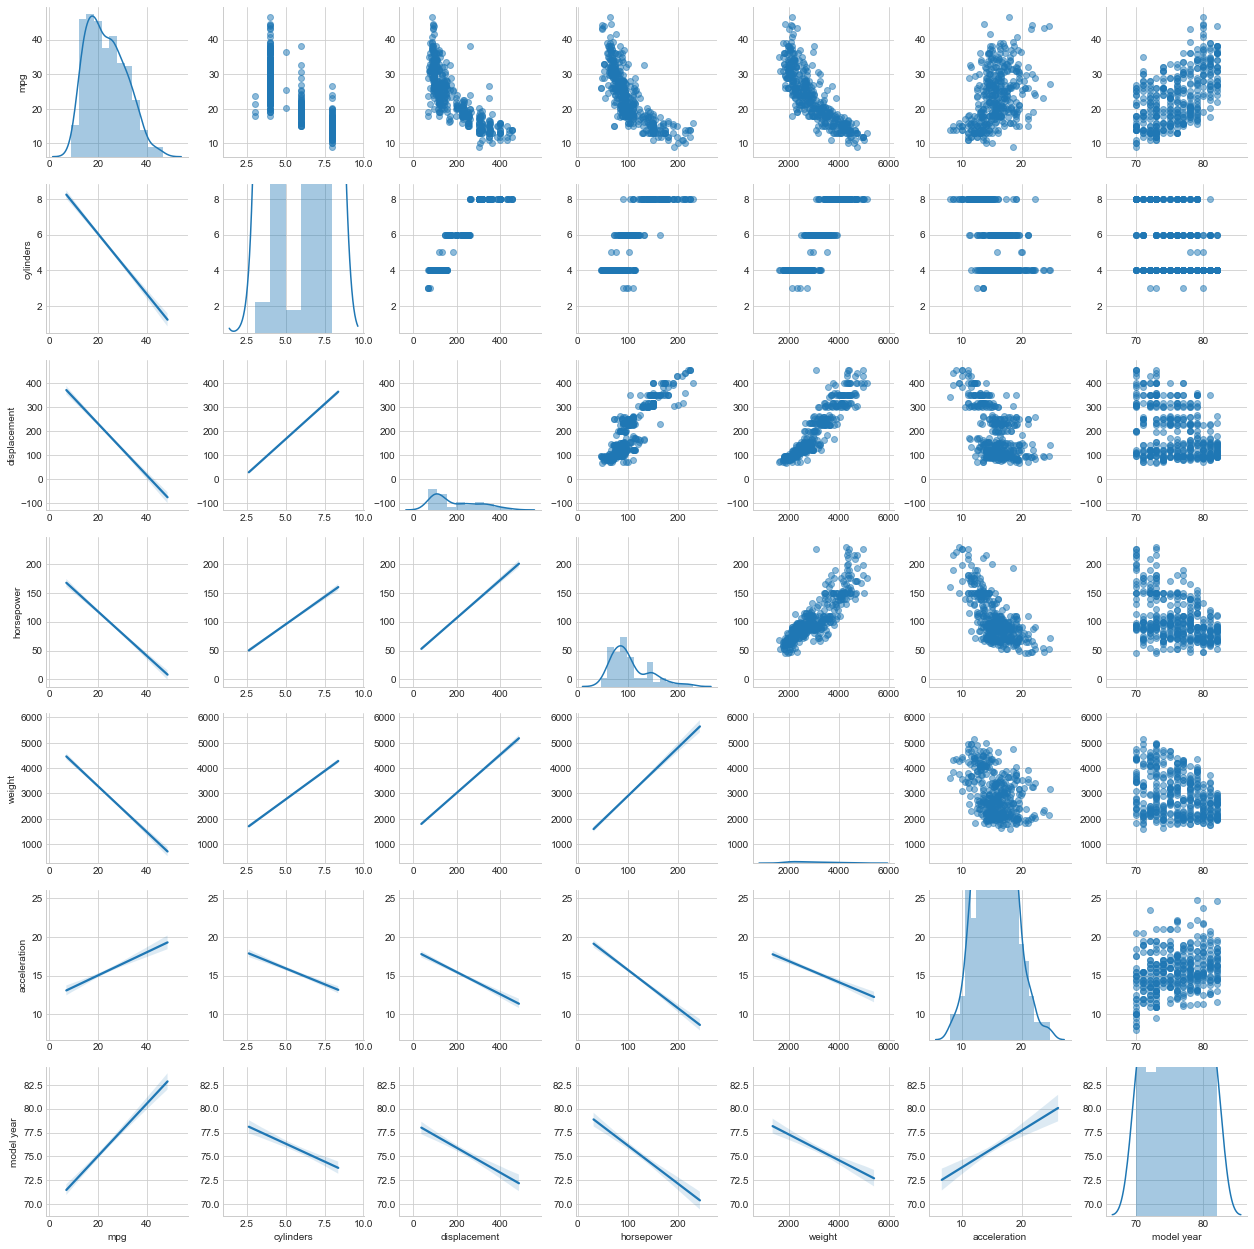

In [7]:
g = sns.PairGrid(df.iloc[:,0:7])
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.distplot)
plt.show()

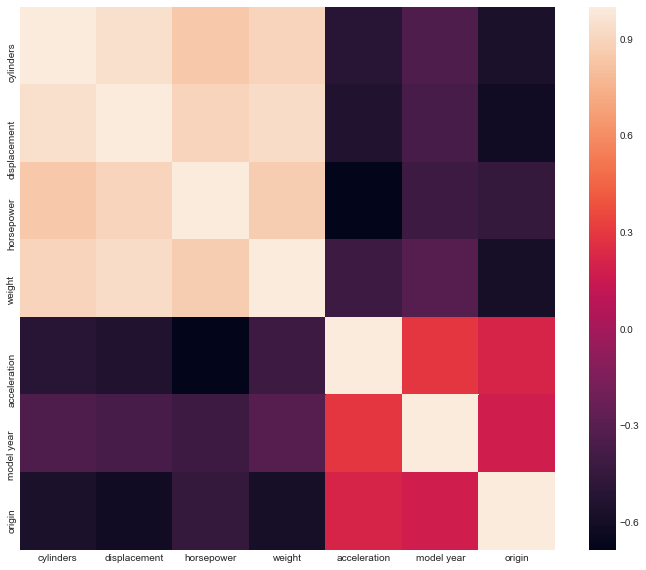

In [8]:
plt.subplots(figsize=(12,10)) 
sns.heatmap(df.iloc[:,1:8].corr())
plt.show()

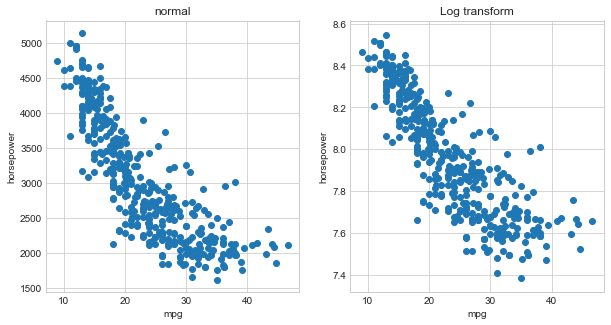

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('normal')
plt.scatter(df['mpg'], df['weight'])
plt.ylabel('horsepower')
plt.xlabel('mpg')
plt.subplot(122)
plt.title('Log transform')
plt.scatter(df['mpg'],np.log(df['weight']))
plt.ylabel('horsepower')
plt.xlabel('mpg')
plt.show()

# Feature engineering
Some of our independent variables are showing similar quadratic relationships to our outcome variable, MPG. These independent variables are weight, horsepower, displacement, and cylinders. This makes sense because the variables are similar. We are going to do a log transform on these variables to create a more linear relationship as shown above, and then a principal component analysis to reduce multicollinearity and keep shared variance. 

In [10]:
#Log transforms
df['cylinders_log'] = np.log10(df['cylinders'])
df['displacement_log'] = np.log10(df['displacement'])
df['horsepower_log'] = np.log10(df['horsepower'])
df['weight_log'] = np.log10(df['weight'])

#Importing PCA and Standard Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Chosing variables for PCA
pca_df = df[['displacement_log','horsepower_log','weight_log']]

#Standardizing variables before PCA
scaler = StandardScaler().fit(pca_df)
pca_df = scaler.transform(pca_df)

#Fiting our PCA
pca = PCA()
pca.fit(pca_df)
print(pca.explained_variance_ratio_)

#Keeping first feature that explains 92% of our variance
pca = pca.set_params(n_components=1)
df['PCA_component_one'] = pca.fit_transform(pca_df)

[ 0.93101549  0.04993847  0.01904604]


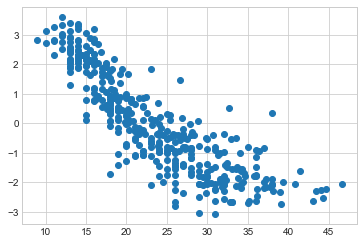

In [11]:
#Verifying linear relationship between PCA and mpg
plt.scatter(df['mpg'], df['PCA_component_one'])
plt.show()

In [12]:
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

regr = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = df[['PCA_component_one','model year']]
Y = df['mpg']

ols_score = cross_val_score(regr, X, Y, cv=5)
knn_score = cross_val_score(knn, X, Y, cv=5)
print(ols_score, '\n', knn_score, '\n')
print('Ordinary Least Squares:',ols_score.mean(),'KNN:', knn_score.mean())

[ 0.4289422   0.75040173  0.80727408  0.75525006  0.2192    ] 
 [ 0.7768883   0.83411539  0.83537975  0.69937162  0.40911974] 

Ordinary Least Squares: 0.592213613717 KNN: 0.710974960124


In [13]:
from sklearn.feature_selection import f_regression

f_test, p_values = f_regression(X, Y)

i = 0
for name in X.columns:
    print(name)
    print('f_test:  {}'.format(f_test[i]))
    print('p_value: {}\n'.format(p_values[i]))
    i += 1

PCA_component_one
f_test:  1110.736490410105
p_value: 3.5425827293286034e-116

model year
f_test:  198.25997203130837
p_value: 1.0757935564067447e-36



In [14]:
regr.fit(X, Y)
df['ols_prediction'] = regr.predict(X)

In [15]:
knn.fit(X,Y)
df['knn_prediction'] = knn.predict(X)

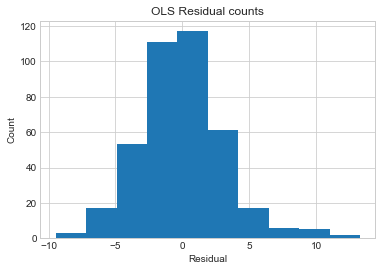

In [16]:
predicted = df['ols_prediction']
actual = df['mpg']

residual = actual - predicted

plt.hist(residual)
plt.title('OLS Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

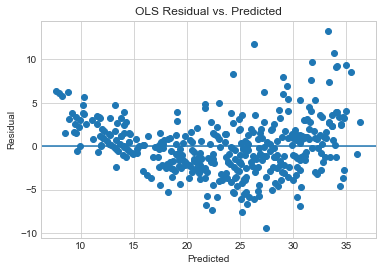

In [17]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('OLS Residual vs. Predicted')
plt.show()

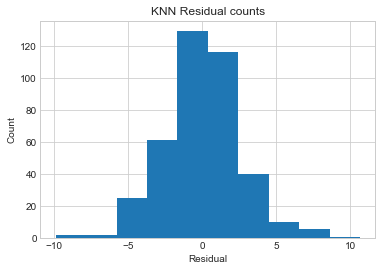

In [18]:
predicted = df['knn_prediction']
actual = df['mpg']

residual = actual - predicted

plt.hist(residual)
plt.title('KNN Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

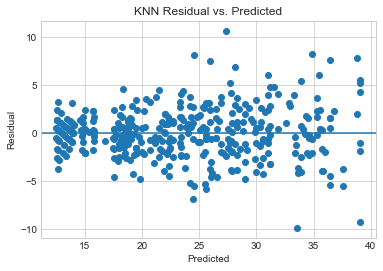

In [19]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('KNN Residual vs. Predicted')
plt.show()

## KNN vs OLS

It seems that OLS handles more variables and larger degress of variance better because of how it fits vectors to the data. Knn will see bad results if there is too much unexplained variance in the data. It also appears that KNN handels quadratic relationships better because of how it fits by nearest points. You can see the remnants of the quadratic relationships in the OLS residual/predicted scatter plot, however those are missing from the KNN residual scatter.